C:\Users\nadee\AppData\Local\Temp\ipykernel_36548\3124528289.py:102: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(acq_value, requires_grad=True)


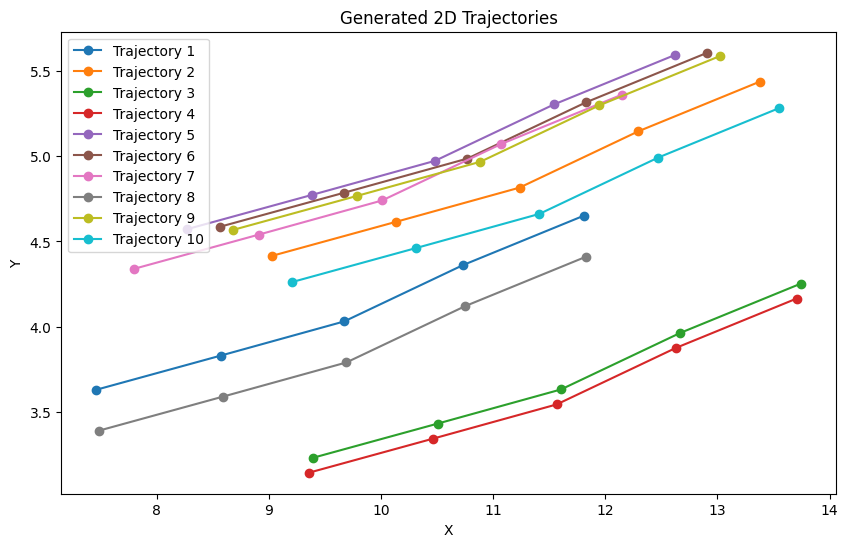

In [81]:
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from scipy.stats import norm
import matplotlib.pyplot as plt

class Generator:
    """
    Mock generator for generating 2D predictions based on latent variable z.
    In practice, replace this with a pre-trained model.
    """
    def predict(self, X, z):
        # Generate 2D path by simulating (x, y) points
        # Assume each point in X is a time step, and we generate a 2D path
        x_path = X[:, 0] + torch.sin(z)  # x-coordinate (example transformation)
        y_path = X[:, 1] + torch.cos(z)  # y-coordinate (example transformation)
        return torch.stack((x_path, y_path), dim=-1)  # Stack into (x, y) format

def rbf_kernel(X1, X2, length_scale=1.0, variance=1.0):
    """
    Radial Basis Function (RBF) kernel for 2D data.
    """
    sqdist = torch.cdist(X1, X2)**2
    return variance * torch.exp(-0.5 * sqdist / length_scale**2)

def pseudo_score(generator, X, z, z_mode):
    """
    Compute the pseudo-score for a latent variable z.
    """
    Y_hat = generator.predict(X, z)
    Y_mode = generator.predict(X, z_mode)
    score = -torch.mean(torch.norm(Y_hat - Y_mode, dim=-1))  # negative distance as pseudo-score
    return score.item()

def warmup(generator, X, w, latent_dim):
    """
    Generate initial samples using Monte Carlo sampling.
    """
    z_samples = torch.randn(w, latent_dim)
    scores = []
    for z in z_samples:
        score = pseudo_score(generator, X, z, z_mode=torch.zeros(latent_dim))
        scores.append(score)
    return z_samples, torch.tensor(scores)

def fit_gp_model(z_samples, scores, length_scale=1.0, variance=1.0, noise=1e-6):
    """
    Fit a Gaussian Process model to the data.
    """
    K = rbf_kernel(z_samples, z_samples, length_scale, variance) + noise**2 * torch.eye(len(z_samples))
    jitter = 1e-6
    K = K + jitter * torch.eye(K.size(0))  # Add small jitter to the diagonal to avoid singular matrix (un-inversable)

    K_inv = torch.inverse(K)
    gp_model = {
        'K': K,
        'K_inv': K_inv,
        'z_train': z_samples,
        'y_train': scores,
        'length_scale': length_scale,
        'variance': variance,
        'noise': noise
    }
    return gp_model

def gp_predict(gp_model, z_candidate):
    """
    Predict mean and variance at z_candidate using GP model.
    """
    K = gp_model['K']
    jitter = 1e-6
    K = K + jitter * torch.eye(K.size(0))  # Add small jitter to the diagonal

    K_inv = gp_model['K_inv']
    z_train = gp_model['z_train']
    y_train = gp_model['y_train']
    length_scale = gp_model['length_scale']
    variance = gp_model['variance']
    noise = gp_model['noise']

    K_s = rbf_kernel(z_train, z_candidate.unsqueeze(0), length_scale, variance)
    K_ss = rbf_kernel(z_candidate.unsqueeze(0), z_candidate.unsqueeze(0), length_scale, variance) + noise**2 * torch.eye(1)

    mu_s = K_s.t().matmul(K_inv).matmul(y_train)
    cov_s = K_ss - K_s.t().matmul(K_inv).matmul(K_s)
    sigma_s = torch.sqrt(cov_s + 1e-8)

    # Ensure mu and sigma are tensors with requires_grad
    mu = mu_s.clone().detach().requires_grad_(True)
    sigma = sigma_s.clone().detach().requires_grad_(True)
    return mu, sigma
    # return mu_s.item(), sigma_s.item()

def acquisition_function(z_candidate, gp_model, beta):
    """
    Compute the acquisition value for a candidate z.
    """
    mu, sigma = gp_predict(gp_model, z_candidate)
    acq_value = mu + beta * sigma
    # print('acq_value:', acq_value)
    return torch.tensor(acq_value, requires_grad=True)

def optimize_acquisition_function(gp_model, latent_dim, beta, num_iter=50, lr=0.1):
    """
    Optimize the acquisition function to find the next z.
    """
    z_candidate = torch.randn(latent_dim, requires_grad=True)
    optimizer = Adam([z_candidate], lr=lr)
    for _ in range(num_iter):
        optimizer.zero_grad()

        acq_value = -acquisition_function(z_candidate, gp_model, beta)
        if not acq_value.requires_grad:
            raise RuntimeError("acquisition function returned a tensor without requires_grad!")
        
        acq_value.backward()
        optimizer.step()
    return z_candidate.detach()

def BOsampler(generator, X, N, w, latent_dim, beta):
    """
    Perform BO sampling to generate N trajectories.
    """
    # Warm-up stage
    z_samples, scores = warmup(generator, X, w, latent_dim)
    trajectories = [generator.predict(X, z) for z in z_samples]

    for n in range(w, N):
        # Fit GP model
        gp_model = fit_gp_model(z_samples, scores)

        # Optimize acquisition function to get next z
        z_next = optimize_acquisition_function(gp_model, latent_dim, beta)

        # Generate trajectory and compute pseudo-score
        score_next = pseudo_score(generator, X, z_next, z_mode=torch.zeros(latent_dim))

        # Update samples and scores
        z_samples = torch.vstack([z_samples, z_next.unsqueeze(0)])
        scores = torch.cat([scores, torch.tensor([score_next])])
        trajectories.append(generator.predict(X, z_next))

    return trajectories

# Example usage
if __name__ == "__main__":
    generator = Generator()

    t1 = [(8.46, 3.59), (9.57, 3.79), (10.67, 3.99), (11.73, 4.32), (12.81, 4.61)]
    t2 = [13.64, 5.8, 12.09, 5.75, 11.37, 5.8, 10.31, 5.97, 9.57, 6.24, 8.73, 6.34, 7.94, 6.5, 7.17, 6.62, 6.47, 6.68, 5.86, 6.82, 5.24, 6.98, 4.87, 7.16, 4.51, 7.58, 4.2, 7.3]
    t2 = list(zip(t2[::2], t2[1::2]))
    
    X = torch.tensor(t1)  # Example observed trajectory points
    N = 10          # Total number of samples
    w = 3          # Number of warm-up samples
    latent_dim = 1  # Dimension of latent variable z
    beta = 0.5      # Exploration-exploitation trade-off

    trajectories = BOsampler(generator, X, N, w, latent_dim, beta)

    # Plot results
    plt.figure(figsize=(10, 6))
    for idx, traj in enumerate(trajectories):
        traj_np = traj.detach().numpy()
        plt.plot(traj_np[:, 0], traj_np[:, 1], marker='o', label=f'Trajectory {idx + 1}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Generated 2D Trajectories')
    plt.legend()
    plt.show()
